# Purpose
This notebook is used to map note_number, velocity, instrument_source, qualities, z to f0_scaled and ld_scaled. The model is created using WaveNet architecture

# Setup google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x
!pip install -qU ddsp[data_preparation]==1.0.1
# !pip install keras-tcn

ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.


# Make directories to save model and data

In [3]:
import os
import datetime


drive_dir = '/content/drive/My Drive/Sound_generation'
checkpoint_dir = os.path.join(drive_dir, 'mapping/z_wavenet_checkpoint')

assert os.path.exists(drive_dir)
print('Drive Directory Exists:', drive_dir)

!mkdir -p "$checkpoint_dir"


Drive Directory Exists: /content/drive/My Drive/Sound_generation


# Download Complete NSynth Guitar Subse

In [4]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

dataset_dir = '/content/drive/MyDrive/Sound_generation/mapping/complete/'
if not os.path.exists(dataset_dir):
  folder_name = folder_download('1-lJfBAVswi8JXR_kKbOkfvNHRNvAZ1TB')

train_dataset_dir = os.path.join(dataset_dir, 'train')
valid_dataset_dir = os.path.join(dataset_dir, 'valid')
test_dataset_dir = os.path.join(dataset_dir, 'test')

train_tfrecord_file = os.path.join(train_dataset_dir, 'complete.tfrecord')
valid_tfrecord_file = os.path.join(valid_dataset_dir, 'complete.tfrecord')
test_tfrecord_file = os.path.join(test_dataset_dir, 'complete.tfrecord')

# Copying data to drive or from drive

In [5]:
# !cp -r  /content/drive/MyDrive/Sound_generation/mapping/complete  ./

# Defining Data class provider


In [6]:
import tensorflow as tf
import ddsp.training.data as data

class CompleteTFRecordProvider(data.RecordProvider):
  def __init__(self,
               file_pattern=None,
               example_secs=4,
               sample_rate=16000,
               frame_rate=250,
               map_func=None):
    super().__init__(file_pattern, example_secs, sample_rate,
                      frame_rate, tf.data.TFRecordDataset)
    self._map_func = map_func

  def get_dataset(self, shuffle=True):
    def parse_tfexample(record):
      features = tf.io.parse_single_example(record, self.features_dict)
      if self._map_func is not None:
        return self._map_func(features)
      else:
        return features

    filenames = tf.data.Dataset.list_files(self._file_pattern, shuffle=shuffle)
    dataset = filenames.interleave(
        map_func=self._data_format_map_fn,
        cycle_length=40,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_tfexample,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

  @property
  def features_dict(self):
    return {
      'sample_name':
        tf.io.FixedLenFeature([1], dtype=tf.string),
      'note_number':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'velocity':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'instrument_source':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'qualities':
        tf.io.FixedLenFeature([10], dtype=tf.int64),
      'audio':
        tf.io.FixedLenFeature([self._audio_length], dtype=tf.float32),
      'f0_hz':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_confidence':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'loudness_db':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'ld_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'z':
        tf.io.FixedLenFeature([self._feature_length * 16], dtype=tf.float32),
    }


# Defining feature mapping function


In [7]:
def features_map(features):
    note_number = features['note_number']
    velocity = features['velocity']
    instrument_source = features['instrument_source']
    qualities = features['qualities']
    f0_scaled = features['f0_scaled']
    ld_scaled = features['ld_scaled']
    z = features['z']

    sequence_length = f0_scaled.shape[0]

    def convert_to_sequence(feature):
        channels = feature.shape[0]
        feature = tf.expand_dims(feature, axis=0)

        feature = tf.broadcast_to(feature, shape=(sequence_length, channels))
        feature = tf.cast(feature, dtype=tf.float32)

        return feature

    # Normalize data
    # 0-127
    note_number = note_number / 127
    velocity = velocity / 127

    # 0-2
    # 0	acoustic, 1	electronic, 2	synthetic
    instrument_source = instrument_source / 2
    f0_variation = f0_scaled * 127.0 - tf.cast(note_number, dtype=tf.float32)
    f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)

    f0_mean = tf.math.reduce_mean(f0_variation)
    f0_variation = tf.where(f0_variation == 0.0, f0_mean, f0_variation)
    f0_variation = tf.expand_dims(f0_variation, axis=-1)

    # Prepare dataset for a sequence to sequence mapping
    note_number = convert_to_sequence(note_number)
    velocity = convert_to_sequence(velocity)
    instrument_source = convert_to_sequence(instrument_source)
    qualities = convert_to_sequence(qualities)

    f0_scaled = tf.expand_dims(f0_scaled, axis=-1)
    ld_scaled = tf.expand_dims(ld_scaled, axis=-1)
    z = tf.reshape(z, shape=(sequence_length, 16))
    # z = tf.math.reduce_mean(z, axis=0)
    # z = convert_to_sequence(z)
    # [note_number, velocity, instrument_source, qualities]

    inputs = tf.concat(
        [note_number, velocity, instrument_source, qualities, z],
        axis=-1)

    targets = tf.concat(
        [f0_variation, ld_scaled],
        axis=-1)

    final_inputs = {
        'inputs': inputs,
        'targets': tf.pad(targets[0:-1, :], [[1, 0], [0, 0]])
    }

    return final_inputs, targets

# Create Datasets

In [8]:
batch_size = 16
example_secs = 4
sample_rate = 16000
frame_rate = 250

# Create train dataset
train_data_provider = CompleteTFRecordProvider(
    file_pattern=train_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

train_dataset = train_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create valid dataset
valid_data_provider = CompleteTFRecordProvider(
    file_pattern=valid_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

valid_dataset = valid_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create test dataset
test_data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

test_dataset = test_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create and compile mapping model
 - WaveNet Implementation 


In [9]:
class ReLU(tf.keras.layers.ReLU):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, inputs, is_synthesis=False):
        return super().call(inputs)



class Conv1D(tf.keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, strides=1, padding='causal',
                 dilation_rate=1, residual_channels=None, *args, **kwargs):
        super().__init__(filters, kernel_size, strides=strides, padding=padding,
                         dilation_rate=dilation_rate)

        self.k = kernel_size
        self.d = dilation_rate

        if kernel_size > 1:
            self.queue_len = kernel_size + (kernel_size - 1) * (dilation_rate - 1)
            self.queue_dim = residual_channels
            self.init_queue()

    def build(self, input_shape):
        super().build(input_shape)

        self.linearized_weights = tf.cast(tf.reshape(self.kernel, [-1, self.filters]), dtype=tf.float32)

    def call(self, inputs, is_synthesis=False):
        if not is_synthesis:
            return super().call(inputs)

        if self.k > 1:
            self.queue = self.queue[:, 1:, :]
            self.queue = tf.concat([self.queue, tf.expand_dims(inputs[:, -1, :], axis=1)], axis=1)

            if self.d > 1:
                inputs = self.queue[:, 0::self.d, :]
            else:
                inputs = self.queue

        outputs = tf.matmul(tf.reshape(inputs, [1, -1]), self.linearized_weights)
        outputs = tf.nn.bias_add(outputs, self.bias)

        # [batch_size, 1(time_len), channels]
        return tf.reshape(outputs, [-1, 1, self.filters])

    def init_queue(self):
        self.queue = tf.zeros([1, self.queue_len, self.queue_dim], dtype=tf.float32)


class ResidualConv1DGLU(tf.keras.Model):
    """
        conv1d + GLU => add condition => residual add + skip connection
    """

    def __init__(self, residual_channels, gate_channels, kernel_size,
                 skip_out_channels=None, dilation_rate=1, **kwargs):
        super().__init__()

        self.residual_channels = residual_channels

        if skip_out_channels is None:
            skip_out_channels = residual_channels

        self.dilated_conv = Conv1D(gate_channels,
                                   kernel_size=kernel_size,
                                   padding='causal',
                                   dilation_rate=dilation_rate,
                                   residual_channels=residual_channels)

        self.conv_c = Conv1D(gate_channels,
                             kernel_size=1,
                             padding='causal')

        self.conv_skip = Conv1D(skip_out_channels,
                                kernel_size=1,
                                padding='causal')
        self.conv_out = Conv1D(residual_channels,
                               kernel_size=1,
                               padding='causal')

    @tf.function
    def call(self, inputs, c):
        x = self.dilated_conv(inputs)
        x_tanh, x_sigmoid = tf.split(x, num_or_size_splits=2, axis=2)

        c = self.conv_c(c)
        c_tanh, c_sigmoid = tf.split(c, num_or_size_splits=2, axis=2)

        x_tanh, x_sigmoid = x_tanh + c_tanh, x_sigmoid + c_sigmoid
        x = tf.nn.tanh(x_tanh) * tf.nn.sigmoid(x_sigmoid)

        s = self.conv_skip(x)
        x = self.conv_out(x)

        x = x + inputs

        return x, s

    def init_queue(self):
        self.dilated_conv.init_queue()

    def synthesis_feed(self, inputs, c):
        x = self.dilated_conv(inputs, is_synthesis=True)
        x_tanh, x_sigmoid = tf.split(x, num_or_size_splits=2, axis=2)

        c = self.conv_c(c, is_synthesis=True)
        c_tanh, c_sigmoid = tf.split(c, num_or_size_splits=2, axis=2)

        x_tanh, x_sigmoid = x_tanh + c_tanh, x_sigmoid + c_sigmoid
        x = tf.nn.tanh(x_tanh) * tf.nn.sigmoid(x_sigmoid)

        s = self.conv_skip(x, is_synthesis=True)
        x = self.conv_out(x, is_synthesis=True)

        x = x + inputs

        return x, s

class CrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes=256, name=None):
        super().__init__()
        # self.num_classes = num_classes

    def call(self, targets, outputs):
        # targets_ = tf.one_hot(targets, depth=self.num_classes)
        targets = tf.split(targets, 2, axis=-1)
        outputs = tf.split(outputs, 2, axis=-1)
        loss_0 = tf.nn.softmax_cross_entropy_with_logits(labels=targets[0], logits=outputs[0])
        loss_1 = tf.nn.softmax_cross_entropy_with_logits(labels=targets[1], logits=outputs[1])
        losses = tf.reduce_mean(loss_1) + tf.reduce_mean(loss_0)

        return losses

In [10]:
class WaveNet(tf.keras.Model):
    def __init__(self):
        super().__init__()

        # self.upsample_network = UpsampleNetwork(upsample_scales)

        self.first_layer = Conv1D(128,
                                  kernel_size=1,
                                  padding='causal')

        self.residual_blocks = []
        self.receptive_field = 1

        for _ in range(1):
            for i in range(10):
                self.residual_blocks.append(
                    ResidualConv1DGLU(128,
                                      256,
                                      kernel_size=2,
                                      skip_out_channels=128,
                                      dilation_rate=2 ** i)
                )
                self.receptive_field += 2 ** i


        self.final_layers = [
            ReLU(),
            Conv1D(128,
                   kernel_size=1,
                   padding='causal'),
            ReLU(),
            Conv1D(2,
                   kernel_size=1,
                   padding='causal')
        ]

    def call(self, inputs):
        c = inputs['inputs']
        temp_input = inputs['targets']

        # c = tf.expand_dims(c, axis=-1)
        # print(c.shape)
        # #c = self.upsample_network(c)
        # c = tf.transpose(tf.squeeze(c, axis=-1), perm=[0, 2, 1])
        # print(c.shape)

        x = self.first_layer(temp_input)
        skips = None
        for block in self.residual_blocks:
            
            x, h = block(x, c)
            
            if skips is None:
                skips = h
            else:
                skips = skips + h

        x = skips
        for layer in self.final_layers:
            x = layer(x)

        return x

    def init_queue(self):
        for block in self.residual_blocks:
            block.init_queue()

    def synthesis(self, inputs):
        c = inputs['inputs']
        temp_input = inputs['targets']
        batch_size, time_len, _ = c.shape
        inputs = tf.zeros([temp_input.shape[0], self.receptive_field, temp_input.shape[2]])
        # inputs = temp_input[:, :1, :]
        outputs = []
        # print(f'Input shape: {inputs.shape}, temp_input : {temp_input.shape}')
        # x = self.first_layer(inputs, is_synthesis=False)
        # print("Done")
        for i in range(time_len):
            c_t = tf.expand_dims(c[:, i, :], axis=1)
            x = self.first_layer(inputs, is_synthesis=False)
            skips = None
            for block in self.residual_blocks:
                # x, h = block.synthesis_feed(x, c_t)
                x, h = block(x, c_t)
                if skips is not None:
                    skips = skips + h
                else:
                    skips = h
            x = skips
            for layer in self.final_layers:
                x = layer(x, is_synthesis=False)
            

            x = x[:, -1:, :]
            inputs = tf.concat([inputs[:, 1:, :], x], axis=1)
            # inputs = tf.concat([inputs, x], axis=1)
            # n = tf.math.minimum(self.receptive_field, inputs.shape[1])
            # inputs = inputs[:, -n:, :]
            # outputs.append(tf.argmax(x, axis=1).numpy())
            outputs.append(x)


        # outputs = np.array(outputs)
        outputs = tf.concat(outputs, axis=1)
        # outputs = inputs[:, -time_len:, :]
        # return np.transpose(outputs, [1, 0])
        return outputs

### Hyperparameters

# Building the model

In [11]:
model = WaveNet()


In [12]:
x_train, y_train = next(iter(train_dataset))

out = model(x_train)

print(model.summary())

Model: "wave_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              multiple                  384       
_________________________________________________________________
residual_conv1dglu (Residual multiple                  106496    
_________________________________________________________________
residual_conv1dglu_1 (Residu multiple                  106496    
_________________________________________________________________
residual_conv1dglu_2 (Residu multiple                  106496    
_________________________________________________________________
residual_conv1dglu_3 (Residu multiple                  106496    
_________________________________________________________________
residual_conv1dglu_4 (Residu multiple                  106496    
_________________________________________________________________
residual_conv1dglu_5 (Residu multiple                  106

# Load checkpoints

In [13]:
import shutil

try:
    shutil.rmtree(checkpoint_dir)
except OSError as e:
    print("Error: %s : %s" % (checkpoint_dir, e.strerror))

In [14]:

checkpoint_file = os.path.join(checkpoint_dir, 'cp.ckpt')

if os.path.isdir(checkpoint_dir) and os.listdir(checkpoint_dir):
    model.load_weights(checkpoint_file)

# Create training callbacks


In [15]:

initial_learning_rate = 1e-3
beta_1 = 0.9
exponential_decay_rate = 0.5


In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    verbose=0,
    save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=20,
    decay_rate=0.96,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule,
                                         beta_1=beta_1)


loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
log_dir = "logs/fit/z_modified_loudness_f0_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model


In [17]:
epochs = 100
steps_per_epoch=100
validation_steps=10

with tf.device('/device:GPU:0'):
  model.fit(train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=[tensorboard_callback, checkpoint])

Epoch 1/100
100/100 [==============================] - 30s 240ms/step - loss: 0.0329 - accuracy: 0.8955 - val_loss: 0.0048 - val_accuracy: 0.9654
Epoch 2/100
100/100 [==============================] - 22s 216ms/step - loss: 0.0035 - accuracy: 0.9456 - val_loss: 0.0020 - val_accuracy: 0.9147
Epoch 3/100
100/100 [==============================] - 21s 215ms/step - loss: 0.0017 - accuracy: 0.9309 - val_loss: 0.0013 - val_accuracy: 0.9325
Epoch 4/100
100/100 [==============================] - 21s 215ms/step - loss: 0.0011 - accuracy: 0.9401 - val_loss: 9.2682e-04 - val_accuracy: 0.9455
Epoch 5/100
100/100 [==============================] - 21s 215ms/step - loss: 9.1139e-04 - accuracy: 0.9445 - val_loss: 7.6824e-04 - val_accuracy: 0.9706
Epoch 6/100
100/100 [==============================] - 21s 213ms/step - loss: 7.5489e-04 - accuracy: 0.9461 - val_loss: 6.7013e-04 - val_accuracy: 0.9441
Epoch 7/100
100/100 [==============================] - 21s 212ms/step - loss: 6.7307e-04 - accuracy: 0.9

# Evaluate the model

In [18]:
model.evaluate(test_dataset,steps=500)

500/500 [==============================] - 49s 94ms/step - loss: 3.7678e-04 - accuracy: 0.9655


[0.00037677562795579433, 0.965512752532959]

In [19]:
gin_file_path = '/content/drive/MyDrive/ddsp_generator/operative_config-30000.gin'
ddsp_model_path = '/content/drive/MyDrive/ddsp_generator'

In [20]:
import ddsp.training
from ddsp.training.preprocessing import F0LoudnessPreprocessor
import gin
import matplotlib.pyplot as plt
# from IPython.display import Audio

sr = 16000

ddsp_dir = '/content/drive/MyDrive/ddsp_generator'

# Parse the gin config.
gin_file = '/content/drive/MyDrive/ddsp_generator/operative_config-30000.gin'
gin.parse_config_file(gin_file)

# Load model
ddsp_model = ddsp.training.models.Autoencoder()
ddsp_model.restore(ddsp_dir)

def map_func(features):
    inputs, outputs = features_map(features)
    return inputs, outputs, features

# Create test dataset
data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=map_func)

dataset = data_provider.get_batch(
    1,
    shuffle=True,
    repeats=-1)

datagen = iter(dataset)

In [23]:
import numpy as np
def get_preds(inputs, features, outputs):

  
  # outputs = mapping_model(inputs)
  # f0_variation_pred, ld_scaled_pred = tf.split(outputs, 2, axis=-1)
  # f0_variation_pred = tf.cast(tf.argmax(f0_variation_pred, axis=-1), dtype=tf.float32)/255.0
  # ld_scaled_pred = tf.cast(tf.argmax(ld_scaled_pred, axis=-1), dtype=tf.float32)/255.0
  # f0_variation_pred = f0_variation_pred*2.0 - 1.0


  f0_variation_pred = outputs[:, :, 0]
  ld_scaled_pred = outputs[:, :, 1]
  z_pred = outputs[:, :, 2:]

  f0_variation_pred = tf.squeeze(f0_variation_pred)
  ld_scaled_pred = tf.squeeze(ld_scaled_pred)
  # z_pred = tf.squeeze(z_pred)

  f0_scaled = np.squeeze(features['f0_scaled'])
  ld_scaled = np.squeeze(features['ld_scaled'])
  # z = tf.reshape(features['z'], shape=z_pred.shape)

  note_number = features['note_number']
  note_number = tf.squeeze(tf.cast(note_number, dtype=tf.float32))

  f0_variation = f0_scaled * 127.0 - tf.cast(note_number, dtype=tf.float32)
  f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)

  f0_mean = tf.math.reduce_mean(f0_variation)
  f0_variation = tf.where(f0_variation == 0.0, f0_mean, f0_variation)
  # f0_variation = tf.expand_dims(f0_variation, axis=-1)

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(f0_variation, label='f0_variation')
  plt.plot(f0_variation_pred, label='f0_variation prediction')
  plt.xlabel('time')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(ld_scaled, label='ld_scaled')
  plt.plot(ld_scaled_pred, label='ld_scaled prediction')
  plt.xlabel('time')
  plt.legend()

  # plt.subplot(2, 2, 3)
  # plt.xlabel('time')
  # plt.ylabel('z')
  # plt.plot(z)
  # plt.ylim([-7., 7.])

  # plt.subplot(2, 2, 4)
  # plt.xlabel('time')
  # plt.ylabel('z prediction')
  # plt.plot(z_pred)
  # plt.ylim([-7., 7.])

  plt.show()

  f0_scaled_pred = (f0_variation_pred + note_number) / 127.0

  f0_scaled_pred = tf.expand_dims(f0_scaled_pred, axis=0)
  ld_scaled_pred = tf.expand_dims(ld_scaled_pred, axis=0)

  # Update the features with predicted f0 and ld
  features['f0_scaled'] = tf.convert_to_tensor(f0_scaled_pred)
  features['ld_scaled'] = tf.convert_to_tensor(ld_scaled_pred)

  f0_hz, loudness_db = F0LoudnessPreprocessor.invert_scaling(
      f0_scaled_pred, ld_scaled_pred)

  features['f0_hz'] = f0_hz
  features['loudness_db'] = loudness_db
  # features['z'] = z_pred

  ddsp_outputs = ddsp_model(features, training=False)
  audio_pred = ddsp_model.get_audio_from_outputs(ddsp_outputs)

  return features['audio'], audio_pred


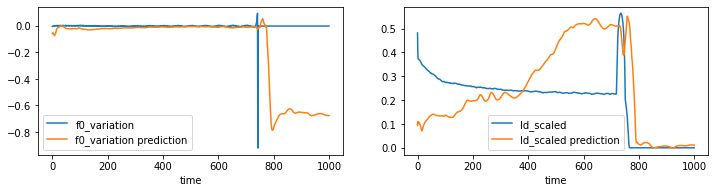

Original Audio


Predicted Audio


In [25]:
import IPython

inputs, outputs, features = next(datagen)
# print(features['sample_name'])

with tf.device('/device:GPU:0'):
  pred_outputs = model.synthesis(inputs)

audio, audio_pred = get_preds(inputs , features, pred_outputs)

print('Original Audio')
IPython.display.display(IPython.display.Audio(audio, rate=sr))

print('Predicted Audio')
IPython.display.display(IPython.display.Audio(audio_pred, rate=sr))

In [26]:

!tensorboard dev upload \
  --logdir logs/fit\
  --name "Mapping network for loudness and F0 using WaveNet" \
  --description "Mapping of note_number, velocity, instrument_source, qualities, z to f0 scaled, and loudness scaled " \
  --one_shot

2021-06-14 16:42:00.375042: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/fit

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&